# P&G CEO Challenge 1st round

This project is our implementation of the idea for a competition, although it was really a pity failing to break into semi-round, it has been really an honor to work with the brilliant teammates. Due to the lack of data support, we choose to use a public dataset similar to the data we expected, turn the blueprint into reality and draw a conclusion to this journey:)
Due to the rules of the competition, we will not disclose any details of our slides, but only try to illustrate the feasibility and some important results, the dataset contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.  http://archive.ics.uci.edu/ml/datasets/Online+Retail+II 

## Environment Setup

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import datetime as dt
from sklearn.cluster import KMeans
from sklearn import preprocessing
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings("ignore")

## Getting and Cleaning Data

There are over 500k records, pretty large a dataframe.

In [2]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")
df.shape

(541909, 8)

There are 8 attributes, "InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID" and "Country". Among them, InvoiceNo is a 6-digit integral number uniquely assigned to each transaction; StockCode is a 5-digit integral number uniquely assigned to each distinct product. 

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


There are a small portion of Description recorded as NaN and nearly a quarter of CustomerID missing information, since we have such a great volume of data and this part of data is extremely hard to impute, we discard them.

In [4]:
df_NAN = df.isna().sum()
df_NAN = df_NAN.to_frame()
df_NAN.columns = ['Count']

df_NAN_percentage = df.isna().sum()/len(df) * 100
df_NAN_percentage = df_NAN_percentage.to_frame()
df_NAN_percentage.columns = ['Percentage']

df_NAN.merge(df_NAN_percentage, left_index=True, right_index=True)

,Count,Percentage
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,1454,0.268311
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135080,24.926694
Country,0,0.000000


In [5]:
#Discard records without Description and CustomerID
df = df.dropna(subset=['Description', 'CustomerID'])
df.shape

(406829, 8)

In [6]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Transform datatype of 'CustomerID' into str, since it only represents the identity code of a unique customer; transform 'InvoiceDate' into datetime.

In [7]:
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [8]:
df_NAN = df.isna().sum()
df_NAN = df_NAN.to_frame()
df_NAN.columns = ['Count']

df_NAN_percentage = df.isna().sum()/len(df) * 100
df_NAN_percentage = df_NAN_percentage.to_frame()
df_NAN_percentage.columns = ['Percentage']

df_NAN.merge(df_NAN_percentage, left_index=True, right_index=True)

,Count,Percentage
InvoiceNo,0,0.0
StockCode,0,0.0
Description,0,0.0
Quantity,0,0.0
InvoiceDate,0,0.0
UnitPrice,0,0.0
CustomerID,0,0.0
Country,0,0.0


After dropping useless rows, there still leaves over 400k records, then we find the duplicate records and further reduce the data volume. 

In [9]:
df.duplicated().sum()

5225

In [10]:
df = df.drop_duplicates()
df.shape

(401604, 8)

## Exploratory Data Analysis

In [11]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,401604,401604,401604,401604.000000,401604,401604.000000,401604,401604
unique,22190,3684,3896,NaN,20460,NaN,4372,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,17841,United Kingdom
freq,542,2065,2058,NaN,543,NaN,7812,356728
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.183273,NaN,3.474064,NaN,NaN
std,NaN,NaN,NaN,250.283037,NaN,69.764035,NaN,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,NaN,NaN


The average number of transactions per customer is about 91, while few of them has significantly high values, the reason may be that many customers of the company are wholesalers.

Average wordcount: 91.85818847209515


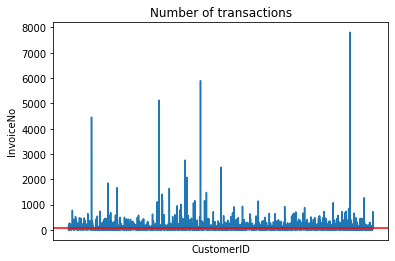

In [12]:
InvoiceNo = df.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
InvoiceNo_avg = InvoiceNo['InvoiceNo'].mean()
print("Average wordcount: {}".format(InvoiceNo_avg))

plt.plot(InvoiceNo['CustomerID'], InvoiceNo['InvoiceNo'])
plt.axhline(y=InvoiceNo_avg, color='r')
plt.xticks(ticks=[])
plt.xlabel("CustomerID")
plt.ylabel("InvoiceNo")
plt.title("Number of transactions")
plt.show()

The average number of product orders completed is about 109, while the most popular one has reached over 2k, which is "WHITE HANGING HEART T-LIGHT HOLDER", a common object for daily use.

Average wordcount: 109.0130293159609
Average wordcount: 783.8937777777778


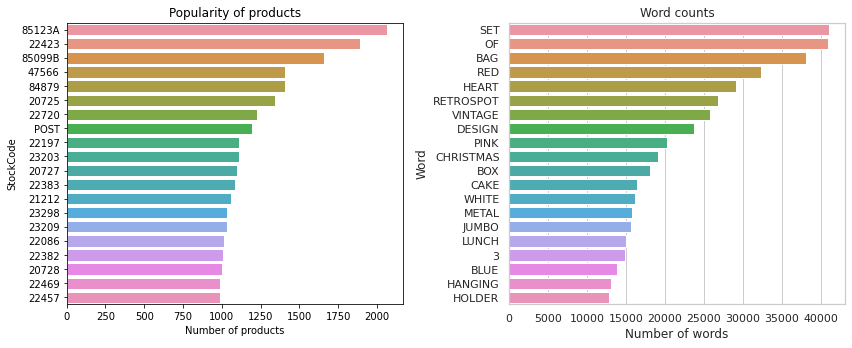

In [13]:
StockCode = df['StockCode'].value_counts().sort_values(ascending=False)
StockCode_avg = StockCode.values.mean()
print("Average wordcount: {}".format(StockCode_avg))
StockCode = StockCode[:20].sort_values(ascending=False)

word_count = df['Description'].str.split(expand=True).stack().value_counts()
word_count_avg = word_count.mean()
print("Average wordcount: {}".format(word_count_avg))
word_count = word_count[:20].sort_values(ascending=False)

plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.set(style="whitegrid")
ax1 = plt.subplot(1, 2, 1)
ax1 = sns.barplot(StockCode.values, StockCode.index)
ax1.set_xlabel("Number of products")
ax1.set_ylabel("StockCode")
ax1.set_title("Popularity of products")

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.barplot(word_count.values, word_count.index)
ax2.set_xlabel("Number of words")
ax2.set_ylabel("Word")
ax2.set_title("Word counts")

plt.tight_layout()

The most popular words include 'SET', 'OF', 'BAG', 'RED' and 'HEART', of which the first one might refer to some small objects, 'BAG' is probably the most purchased item for all ages, 'RED' and 'HEART' are likely to represent the color and shape that are both common for goods.

It is werid that there is negative value for 'Quantity', the common patern for these negative rows is a prefix 'C' of their 'InvoiceNo', which represents 'Cancelation'. 

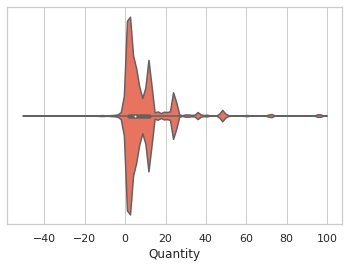

In [14]:
#We ignore the extremely large values since they influce the distribution plot too much.
ax = sns.violinplot(x=df[(df['Quantity']<100) & (df['Quantity']>-50)]['Quantity'], color='tomato')

In [15]:
#Select cancelation records
df_cancel = df[df['Quantity'] < 0]
df_cancel.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Some of rows have corresponding transactions of which the 'Quantity' is exactly the absolute value, we discard both rows as it will not reflect the willingness to purchase; while some are without corresponding purchasing records, probably because the purchase was done before 01/12/2009.

In [0]:
A = [] #Cancelation with corresponding purchase record
B = [] #Cancelation without corresponding purchase record
index_cor = [] #Index of corresponding records
for index, attributes in df_cancel.iterrows():
    df_cor = df[(df['StockCode'] == attributes[1]) & (df['Description'] == attributes[2]) & (df['Quantity'] == -attributes[3]) & (df['CustomerID'] == attributes[6])]
    if df_cor.shape[0] == 0:
        B.append(index)
    else:
        A.append(index)
        index_cor.append(df_cor.index)

In [17]:
print('Cancelation with corresponding purchase record: {}'.format(len(A)))
print('Index of corresponding records: {}'.format(len(index_cor)))
print('Cancelation without corresponding purchase record: {}'.format(len(B)))

Cancelation with corresponding purchase record: 3224
Index of corresponding records: 3224
Cancelation without corresponding purchase record: 5648


It is unreasonable to count the influence of cancelation if the purchase date is behind the cancelation date, as the order cancelled is before the start date of the dateset, thus we delete rows and their corresponding purchase order.

In [0]:
#Define a function to return the closest date if there are multiple corresponding dates.
def nearest(items, pivot):
  return min(items, key=lambda x: abs(x - pivot))

#Distinguish whether the corresponding date is behind the cancelation date.
A_True = []
A_False = []
index_cor_True = []
n = 0
for a in A:
  CancelDate = df.loc[a].InvoiceDate
  CancelDate = np.datetime64(CancelDate)
  CorrespondDate = df.loc[index_cor[n]].InvoiceDate
  if CorrespondDate[CorrespondDate.values < CancelDate].shape[0] > 0:
    A_True.append(a)
    TrueCorrespondDate = CorrespondDate[CorrespondDate.values < CancelDate]
    NearestDate = nearest(TrueCorrespondDate.values, CancelDate)
    index_cor_True.append(TrueCorrespondDate[TrueCorrespondDate.values == NearestDate].index.values[0])
  else:
    A_False.append(a)
  n = n + 1

In [19]:
print('Cancelation after purchase: {}'.format(len(A_True)))
print('Index of corresponding records: {}'.format(len(index_cor_True)))
print('Cancelation before purchase: {}'.format(len(A_False)))

Cancelation after purchase: 2889
Index of corresponding records: 2889
Cancelation before purchase: 335


In [20]:
#Delete cancelation records without corresponding records directly, delete both cancelation records and their corresponding records as well
df = df[~df.index.isin(B)]
df = df[~df.index.isin(A_False)]
df = df[~df.index.isin(A_True)]
df = df[~df.index.isin(index_cor_True)]
df.shape

(389901, 8)

In [21]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,389901,389901,389901,389901.000000,389901,389901.00000,389901,389901
unique,18400,3651,3863,NaN,17165,NaN,4328,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,17841,United Kingdom
freq,542,2011,2004,NaN,542,NaN,7577,346929
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.676613,NaN,3.07818,NaN,NaN
std,NaN,NaN,NaN,46.803530,NaN,21.54290,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,0.00000,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.25000,NaN,NaN


Altough the highest quantity is above 12k, the majority are about 1, consistent with our intuitive that most are one-time consumers.

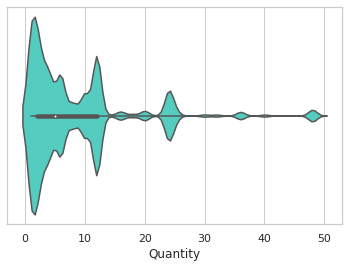

In [22]:
ax = sns.violinplot(x=df[df['Quantity']<50]['Quantity'], color='turquoise')

As the dataset is aranged by each transaction and each product, we add another column to record the total value per transaction. The result is similar to that of InvoiceNo, only few wholesalers contribute to the high-value transaction, the rest only count for about 461 on average.




Average total value: 461.4301888043478


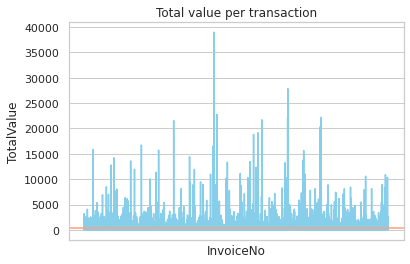

In [23]:
df['TotalValue'] = df['Quantity'] * df['UnitPrice']
TotalValue = df.groupby(by='InvoiceNo').sum()['TotalValue']

TotalValue_avg = TotalValue.values.mean()
print("Average total value: {}".format(TotalValue_avg))

plt.plot(TotalValue.index, TotalValue.values, color='skyblue')
plt.axhline(y=TotalValue_avg, color='lightsalmon')
plt.xticks(ticks=[])
plt.xlabel("InvoiceNo")
plt.ylabel("TotalValue")
plt.title("Total value per transaction")
plt.show()

To compare sales on each month, we add a column indicating month from the attribute 'InvoiceDate', it is clear from the plot that November witnessed the highest sale, consistent with our experience that it was the time preparing for the Christmas.

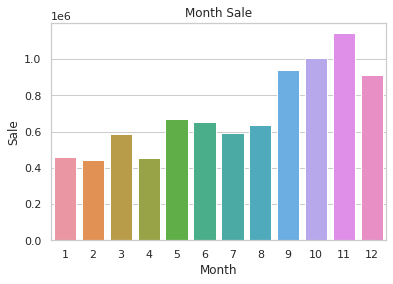

In [24]:
df['Month'] = df['InvoiceDate'].dt.month

MonthSale = df.groupby(by='Month').sum()['TotalValue']

ax = sns.barplot(MonthSale.index, MonthSale.values)
ax.set_xlabel("Month")
ax.set_ylabel("Sale")
ax.set_title("Month Sale")
plt.show()

From the map, it is clear that the majority of orders are in the UK,radiating to other European, Asian and African countries. 

In [25]:
CountrySale = df.groupby(by='Country').sum()['TotalValue']

dict_CS = dict(
    type = 'choropleth',
    locations = CountrySale.index,
    locationmode = 'country names',
    z = CountrySale,
    text = CountrySale.index,
    colorbar = {'title': 'Country Sale'},
    colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],
    reversescale = False
               )

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [dict_CS], layout = layout)
iplot(choromap, validate=False)

## Implementation of the plan
### Step1: Customer values analysis with RFML
RFM is the classical method to evaluate customer values, commonly used in marketing to increase profits from different customers with targeted strategies. A potential problem is that it may leak important information, say 2 customers made same number of purchases, with same value of monetary and same most recent date, but one of them has started membership long time ago, the other not, it will be unreasonable to regard the 2 as same customers, hence we add another factor 'Length' to indicate the period each customer's membership.

In [26]:
#Set the latest time as the current date
Latest_time = df['InvoiceDate'].max()
print("The latest time in the dataset is: {}".format(Latest_time))

The latest time in the dataset is: 2011-12-09 12:50:00


In [0]:
now = Latest_time.date()

In [0]:
#Add a column to record extracted date from InvoiceDate
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [29]:
#Create a dataframe to record the first and last date each customer made purchase
df_recency = df.groupby(by='CustomerID', as_index=False)['Date'].min()
df_recency['LastDate'] = (df.groupby(by='CustomerID', as_index=False)['Date']).max()['Date']
df_recency.columns = ['CustomerID', 'FirstDate', 'LastDate']

#Add a column to record calculated recency
df_recency['Recency'] = now - df_recency['LastDate']
df_recency['Recency'] = df_recency['Recency'].astype('timedelta64[D]')

#Add a column to record calculated length
df_recency['Length'] = df_recency['LastDate'] - df_recency['FirstDate']
df_recency['Length'] = df_recency['Length'].astype('timedelta64[D]')

#Create a dataframe to record the frequency of purchases
df_frequency = df[['CustomerID', 'InvoiceNo']].groupby(by='CustomerID', as_index=False)['InvoiceNo'].count()

#Create a dataframe to record the monetary
df_monetary = df[['CustomerID', 'TotalValue']].groupby(by='CustomerID', as_index=False)['TotalValue'].sum()

#Create a dataframe to store all the RFML related attributes
df_RFML = pd.DataFrame(columns=[])
df_RFML['CustomerID'] = df_recency['CustomerID']
df_RFML['Recency'] = df_recency['Recency']
df_RFML['Frequency'] = df_frequency['InvoiceNo']
df_RFML['Monetary'] = df_monetary['TotalValue']
df_RFML['Length'] = df_recency['Length']
df_RFML.set_index('CustomerID', inplace=True, drop=True)
df_RFML.head()

,Recency,Frequency,Monetary,Length
CustomerID,,,,
12347,2.0,182,4310.00,365.0
12348,75.0,31,1797.24,283.0
12349,18.0,73,1757.55,0.0
12350,310.0,17,334.40,0.0
12352,36.0,78,2385.71,260.0


In [30]:
df_RFML.describe()

,Recency,Frequency,Monetary,Length
count,4328.000000,4328.000000,4328.000000,4328.000000
mean,92.202403,90.088031,1961.717993,130.754621
std,100.177290,223.610373,8415.183844,132.172125
min,0.000000,1.000000,0.000000,0.000000
25%,17.000000,17.000000,303.930000,0.000000
50%,50.000000,41.000000,659.145000,93.000000
75%,142.000000,98.000000,1637.762500,252.000000
max,373.000000,7577.000000,279810.020000,373.000000


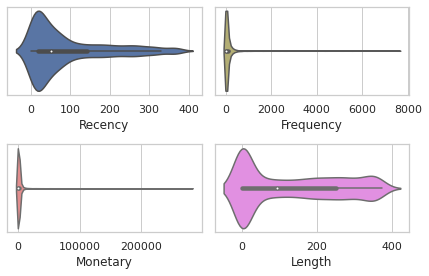

In [31]:
plt.subplot(221)

ax1 = plt.subplot(2, 2, 1)
ax1 = sns.violinplot(x=df_RFML['Recency'])

ax2 = plt.subplot(2, 2, 2)
ax2 = sns.violinplot(x=df_RFML['Frequency'], color='darkkhaki')

ax3 = plt.subplot(2, 2, 3)
ax3 = sns.violinplot(x=df_RFML['Monetary'], color='lightcoral')

ax4 = plt.subplot(2, 2, 4)
ax4 = sns.violinplot(x=df_RFML['Length'], color='violet')

plt.tight_layout()

The distribution of Recency shows that the majority of customers completed transaction recently, which is an inspiring news, since they are the ones more likely to convert to make purchase, thus we choose the customers whose recency is smaller than the 25th percentile; As the distribution of Frequency and Monetary are pretty similar, we choose the 75th percentile as threshold; While the distribution of Length is a bit different, it seems reasonable to choose the 50th percentile as the threshold. 

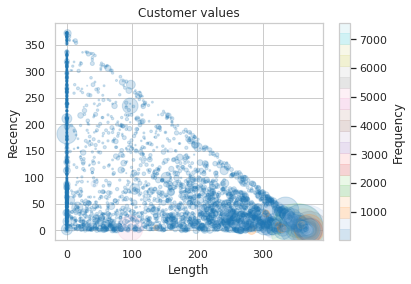

In [32]:
plt.scatter(df_RFML['Length'], df_RFML['Recency'], s=df_RFML['Monetary']*1e-2, c=df_RFML['Frequency'], alpha=0.2, cmap='tab20')
plt.xlabel("Length")
plt.ylabel("Recency")
plt.title("Customer values")
cbar = plt.colorbar()
cbar.set_label('Frequency')
plt.show()

The distribution of Recency to Length is a triangle because there is only data in this one year range. The size of points represents the monetary and the color represents the frequency, the purpose of our campaign is to transform more customers to the right bottom side of the figure, with its size enlarged and color lightened.

In [33]:
#Select the part we are concerned with
df_selected = df_RFML[(df_RFML['Recency']<17) & (df_RFML['Frequency']>98) & (df_RFML['Monetary']>1637) & (df_RFML['Length']>93)]
CustomerSelected = list(df_selected.index)
df[df['CustomerID'].isin(CustomerSelected)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,Month,Date
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583,France,45.0,12,2010-12-01
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583,France,10.2,12,2010-12-01
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,15.6,12,2010-12-01


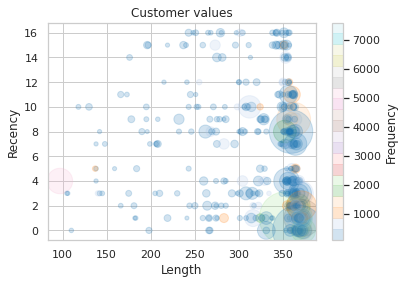

In [34]:
plt.scatter(df_selected['Length'], df_selected['Recency'], s=df_selected['Monetary']*1e-2, c=df_selected['Frequency'], alpha=0.2, cmap='tab20')
plt.xlabel("Length")
plt.ylabel("Recency")
plt.title("Customer values")
cbar = plt.colorbar()
cbar.set_label('Frequency')
plt.show()

### Step2: Customer clustering with KMeans algorithm

In [35]:
df_selected.head()

,Recency,Frequency,Monetary,Length
CustomerID,,,,
12347,2.0,182,4310.00,365.0
12362,3.0,263,5177.38,292.0
12388,15.0,100,2780.66,311.0
12417,3.0,191,3629.15,354.0
12423,0.0,124,1849.11,353.0


In [36]:
#Scale the data
df_scaled = preprocessing.scale(df_selected)
df_scaled

array([[-0.88549977, -0.3204367 , -0.22414946,  0.73154952],
       [-0.67459079, -0.19056684, -0.18889611, -0.41239234],
       [ 1.85631698, -0.45190989, -0.28630717, -0.11465405],
       ...,
       [ 0.16904514, -0.33166002, -0.29498862,  0.4651521 ],
       [-0.88549977, -0.34609001, -0.27419866, -1.16457329],
       [-0.67459079,  0.54375904, -0.31618542,  0.24576599]])

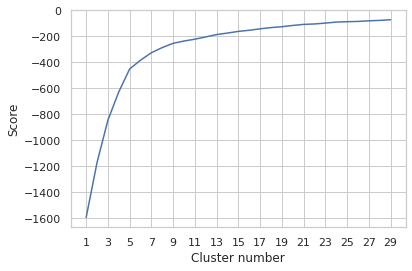

In [37]:
#Search for the best cluster number for KMeans
C = range(1, 30)
kmeans = [KMeans(n_clusters=i) for i in C]
score = [kmeans[i].fit(df_scaled).score(df_scaled) for i in range(len(C))]
plt.plot(C, score)
plt.xticks(list(range(1, 30, 2)))
plt.xlabel("Cluster number")
plt.ylabel("Score")
plt.show()

In [97]:
#Select 5 clusters to fit the data
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_scaled)

#Add a column to save the cluster result
df_selected['cluster'] = kmeans.labels_
df_selected[df_selected['cluster'] == 0].head()

,Recency,Frequency,Monetary,Length,cluster
CustomerID,,,,,
12518,0.0,124,2056.89,110.0,0
12560,5.0,105,2134.01,138.0,0
12562,8.0,168,3781.74,190.0,0
12569,2.0,186,4088.69,250.0,0
12615,2.0,105,2291.19,166.0,0


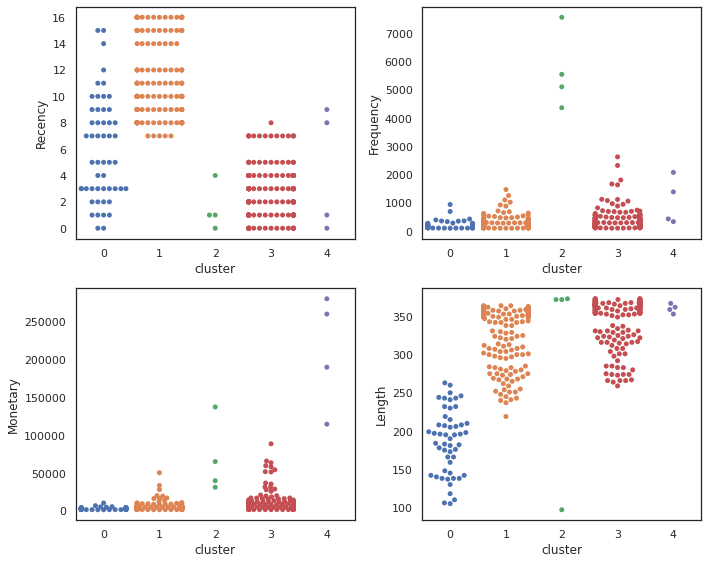

In [98]:
plt.figure(figsize=(10, 8))
plt.subplot(221)

plt.subplot(2, 2, 1)
ax1 = sns.swarmplot(df_selected['cluster'], df_selected['Recency'])

plt.subplot(2, 2, 2)
sns.swarmplot(df_selected['cluster'], df_selected['Frequency'])

plt.subplot(2, 2, 3)
sns.swarmplot(df_selected['cluster'], df_selected['Monetary'])

plt.subplot(2, 2, 4)
sns.swarmplot(df_selected['cluster'], df_selected['Length'])

plt.tight_layout()

Basicly, the 5 clusters own their characteristics and relatively clear to see the difference between groups: cluster0, they are casual browsers in the period of recent time; cluster1, they are the loyal customers, although in small number, contribute high transaction values; cluster2, it is a group worth more attention, because they were once the loyal customers, but recently have not pay visit to the stores at all, it will be really a shame to lose such large number of ex-loyal customers; cluster3, this is another special group, likely to be a long-term wholesaler, since there are merely few of them, but makes up the highest monetary with low frequency; cluster4, they are the loyal low-frequency customers, probably they have been used to purchase certain items regularly from the merchant.

### Step3: Customer characteristic exploration with NLP methods
Despite the simple word count we've done in exploratory data analysis, here we make a much detailed investigation into the description information.

Average wordcount: 764.8678571428571


Text(0.5, 1.0, 'Word counts')

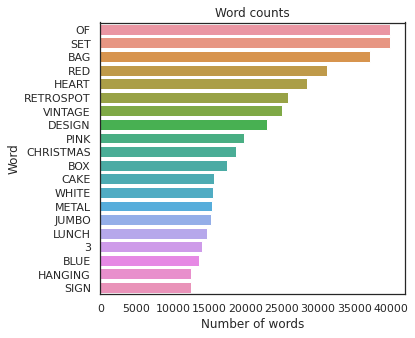

In [99]:
word_count = df['Description'].str.split(expand=True).stack().value_counts()
word_count_avg = word_count.mean()
print("Average wordcount: {}".format(word_count_avg))
word_count = word_count[:20].sort_values(ascending=False)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 2)
ax = sns.barplot(word_count.values, word_count.index)
ax.set_xlabel("Number of words")
ax.set_ylabel("Word")
ax.set_title("Word counts")

In [100]:
df_platinum = df[df['CustomerID'].isin(CustomerSelected)]
df_platinum = df_platinum.reset_index(drop=True)
df_platinum.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,Month,Date
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583,France,45.0,12,2010-12-01
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583,France,10.2,12,2010-12-01
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,15.6,12,2010-12-01


In [101]:
#Tokenize Description into words
nltk.download('punkt')
df_platinum['tokenized_description'] = df_platinum.apply(lambda row: nltk.word_tokenize(row['Description']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [102]:
df_platinum.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,Month,Date,tokenized_description
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[ALARM, CLOCK, BAKELIKE, PINK]"
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[ALARM, CLOCK, BAKELIKE, RED]"
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583,France,45.0,12,2010-12-01,"[ALARM, CLOCK, BAKELIKE, GREEN]"
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583,France,10.2,12,2010-12-01,"[PANDA, AND, BUNNIES, STICKER, SHEET]"
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,15.6,12,2010-12-01,"[STARS, GIFT, TAPE]"


In [0]:
#Filter out numbers and punctuations
def filter(mylist):
  no_integers = [x for x in mylist if x.isalpha()]
  return no_integers

In [0]:
df_platinum['tokenized_description'] = df_platinum['tokenized_description'].apply(lambda x: filter(x))

In [105]:
df_platinum.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,Month,Date,tokenized_description
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[ALARM, CLOCK, BAKELIKE, PINK]"
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[ALARM, CLOCK, BAKELIKE, RED]"
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583,France,45.0,12,2010-12-01,"[ALARM, CLOCK, BAKELIKE, GREEN]"
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583,France,10.2,12,2010-12-01,"[PANDA, AND, BUNNIES, STICKER, SHEET]"
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,15.6,12,2010-12-01,"[STARS, GIFT, TAPE]"


In [106]:
#Filter out stop words
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#Convert to lowercase
df_platinum['tokenized_description'] = df_platinum['tokenized_description'].apply(lambda x: [w.lower() for w in x])

In [0]:
df_platinum['tokenized_description'] = df_platinum['tokenized_description'].apply(lambda x: [item for item in x if item not in stop_words])

In [109]:
df_platinum.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,Month,Date,tokenized_description
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[alarm, clock, bakelike, pink]"
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[alarm, clock, bakelike, red]"
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583,France,45.0,12,2010-12-01,"[alarm, clock, bakelike, green]"
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583,France,10.2,12,2010-12-01,"[panda, bunnies, sticker, sheet]"
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,15.6,12,2010-12-01,"[stars, gift, tape]"


In [110]:
BoW = []
for i in range(len(df_platinum)):
  BoW.extend(df_platinum['tokenized_description'][i])
len(BoW)

597772

In [0]:
counts = Counter(BoW)

Text(0.5, 1.0, 'Word counts')

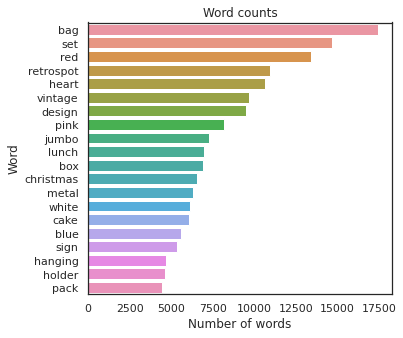

In [112]:
CommonWords = [word for word,cnt in counts.most_common(20)]
WordsCount = [cnt for word,cnt in counts.most_common(20)]
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 2)
ax = sns.barplot(WordsCount, CommonWords)
ax.set_xlabel("Number of words")
ax.set_ylabel("Word")
ax.set_title("Word counts")

In [0]:
#Remove quantifier and color words
quantifier_words = ['bag', 'set', 'box']
color_words = ['red', 'pink', 'white', 'blue', 'green', 'black']
df_platinum['tokenized_description'] = df_platinum['tokenized_description'].apply(lambda x: [item for item in x if item not in quantifier_words])
df_platinum['tokenized_description'] = df_platinum['tokenized_description'].apply(lambda x: [item for item in x if item not in color_words])

In [114]:
df_platinum.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,Month,Date,tokenized_description
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[alarm, clock, bakelike]"
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[alarm, clock, bakelike]"
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583,France,45.0,12,2010-12-01,"[alarm, clock, bakelike]"
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583,France,10.2,12,2010-12-01,"[panda, bunnies, sticker, sheet]"
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,15.6,12,2010-12-01,"[stars, gift, tape]"


In [115]:
BoW = []
for i in range(len(df_platinum)):
  BoW.extend(df_platinum['tokenized_description'][i])
len(BoW)

520774

In [0]:
counts = Counter(BoW)

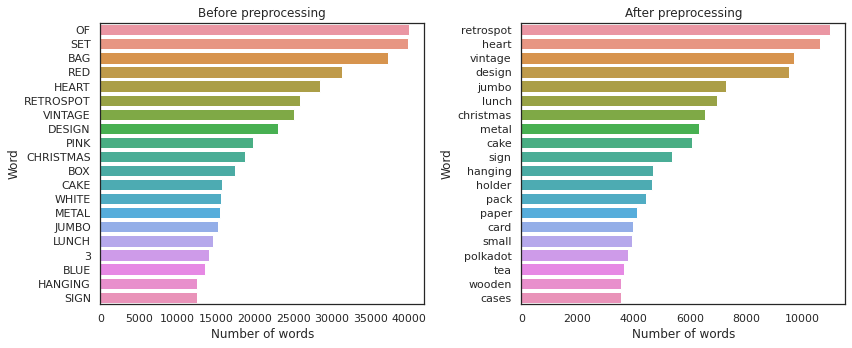

In [117]:
CommonWords = [word for word,cnt in counts.most_common(20)]
WordsCount = [cnt for word,cnt in counts.most_common(20)]

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
ax = sns.barplot(word_count.values, word_count.index)
ax.set_xlabel("Number of words")
ax.set_ylabel("Word")
ax.set_title("Before preprocessing")

ax = plt.subplot(1, 2, 2)
ax = sns.barplot(WordsCount, CommonWords)
ax.set_xlabel("Number of words")
ax.set_ylabel("Word")
ax.set_title("After preprocessing")

plt.tight_layout()

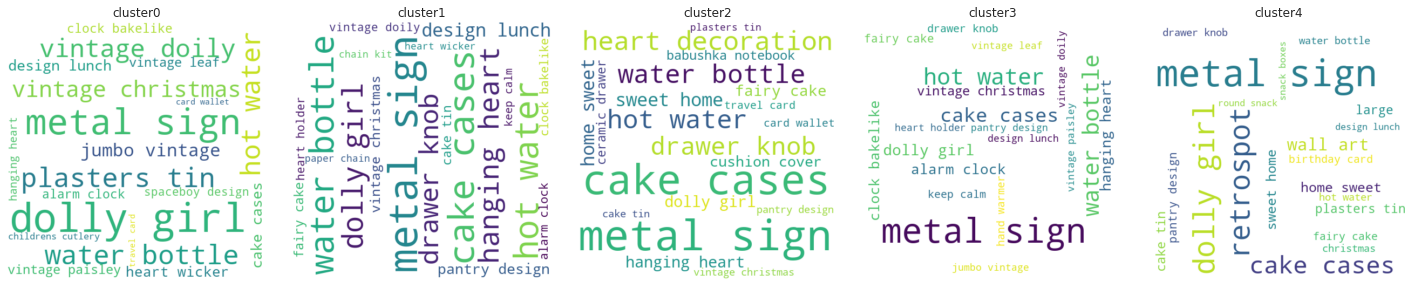

In [118]:
plt.figure(figsize=(20, 4))
plt.subplot(151)

for n in range(5):
  #Select customers in each cluster
  CustomerID_selected = df_selected[df_selected['cluster']==n].index
  Platinum_selected = df_platinum[df_platinum['CustomerID'].isin(CustomerID_selected)]
  Platinum_selected.reset_index(inplace=True, drop=True)

  #Create BoW to store all the words
  sub_BoW = []
  for i in range(len(Platinum_selected)):
    sub_BoW.extend(Platinum_selected['tokenized_description'][i])

  #Turn into string
  text = ""
  for word in sub_BoW:
    text = text + " " + word

  #Create wordcloud
  wordcloud = WordCloud(width=480, height=480, max_words=20, background_color='white', prefer_horizontal=0.7, relative_scaling=1).generate(text)

  plt.subplot(1, 5, n+1)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.margins(x=0, y=0)
  plt.title("cluster" + str(n))

plt.tight_layout()
plt.show()

A problem with simply counting word frequency is that there are common goods in all clusters, like 'bag', 'jumbo' and 'lunch', etc. Hence we apply TF-IDF to perform a normalization.

In [0]:
document = ['', '', '', '', '']

#Create BoW text for each cluster
for n in range(5):
  #Select customers in each cluster
  CustomerID_selected = df_selected[df_selected['cluster']==n].index
  Platinum_selected = df_platinum[df_platinum['CustomerID'].isin(CustomerID_selected)]
  Platinum_selected.reset_index(inplace=True, drop=True)

  #Store all the words in document
  sub_BoW = []
  for i in range(len(Platinum_selected)):
    sub_BoW.extend(Platinum_selected['tokenized_description'][i])

  #Turn into string
  for word in sub_BoW:
    document[n] = document[n] + " " + word

In [0]:
#Apply TF-IDF
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(document)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_TFIDF = pd.DataFrame(denselist, columns=feature_names)

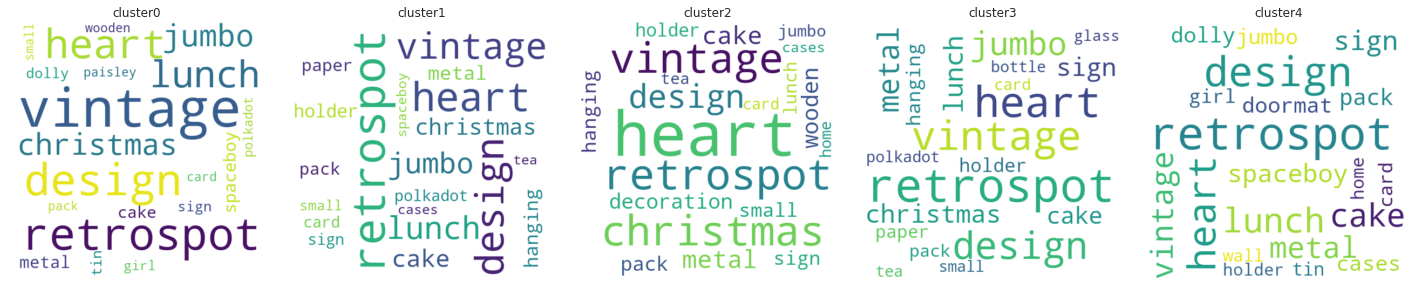

In [121]:
#Create wordcloud
plt.figure(figsize=(20, 4))
plt.subplot(151)

words_names = df_TFIDF.columns
for n in range(5):
  d = {}
  words_freq = df_TFIDF.loc[n]
  for i in range(len(words_names)):
    d[words_names[i]] = words_freq[i]
  wordcloud = WordCloud(width=480, height=480, max_words=20, background_color='white', prefer_horizontal=0.7, relative_scaling=1)
  wordcloud.generate_from_frequencies(frequencies=d)

  plt.subplot(1, 5, n+1)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.margins(x=0, y=0)
  plt.title("cluster" + str(n))
  
plt.tight_layout()
plt.show()

Cluster0 seem to be the loyal fans of vintage and paid certain attention to presents related to Christmas, combined with the fact that they are mostly casual browsers in recent period, they were likely to start preparing for the upcoming Christmas; cluster1 show great interst in heart design, combined with the fact that they are loyal customers, they might be the ones particularly interested in certain type of products by the merchant; cluster2 show similar characteristics to cluster1, but were former loyal customers; cluster3 is less weighted on Christmas, consistent with the fact that they are the long-term customers, less influenced by the festivals; cluster4 has not even shown purchase of Christmas topics, probably because they have turned to other merchants, aka, we have unfortunately lost them.

### Step4: Customer recommendation with collaborative filtering

In [122]:
df_platinum.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,Month,Date,tokenized_description
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[alarm, clock, bakelike]"
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583,France,90.0,12,2010-12-01,"[alarm, clock, bakelike]"
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583,France,45.0,12,2010-12-01,"[alarm, clock, bakelike]"
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583,France,10.2,12,2010-12-01,"[panda, bunnies, sticker, sheet]"
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583,France,15.6,12,2010-12-01,"[stars, gift, tape]"


In [123]:
#Cluster0
CustomerID_selected = df_selected[df_selected['cluster']==0].index
Platinum_selected = df_platinum[df_platinum['CustomerID'].isin(CustomerID_selected)]
Platinum_selected.reset_index(inplace=True, drop=True)
Platinum_selected.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,Month,Date,tokenized_description
0,546922,22355,CHARLOTTE BAG SUKI DESIGN,10,2011-03-18 09:59:00,0.85,14110,United Kingdom,8.50,3,2011-03-18,"[charlotte, suki, design]"
1,546922,20723,STRAWBERRY CHARLOTTE BAG,10,2011-03-18 09:59:00,0.85,14110,United Kingdom,8.50,3,2011-03-18,"[strawberry, charlotte]"
2,546922,15056N,EDWARDIAN PARASOL NATURAL,3,2011-03-18 09:59:00,5.95,14110,United Kingdom,17.85,3,2011-03-18,"[edwardian, parasol, natural]"
3,546922,47566,PARTY BUNTING,4,2011-03-18 09:59:00,4.95,14110,United Kingdom,19.80,3,2011-03-18,"[party, bunting]"
4,546922,82552,WASHROOM METAL SIGN,12,2011-03-18 09:59:00,1.45,14110,United Kingdom,17.40,3,2011-03-18,"[washroom, metal, sign]"


In [0]:
#Create a sparse matrix to store customer-product pairs
df_sparse = pd.DataFrame(index=list(set(Platinum_selected['CustomerID'])), columns=list(set(Platinum_selected['StockCode'])))

In [0]:
for i in range(len(Platinum_selected)):
  df_sparse[Platinum_selected.loc[i]['StockCode']][Platinum_selected.loc[i]['CustomerID']] = 1

In [126]:
df_sparse.shape

(52, 2056)

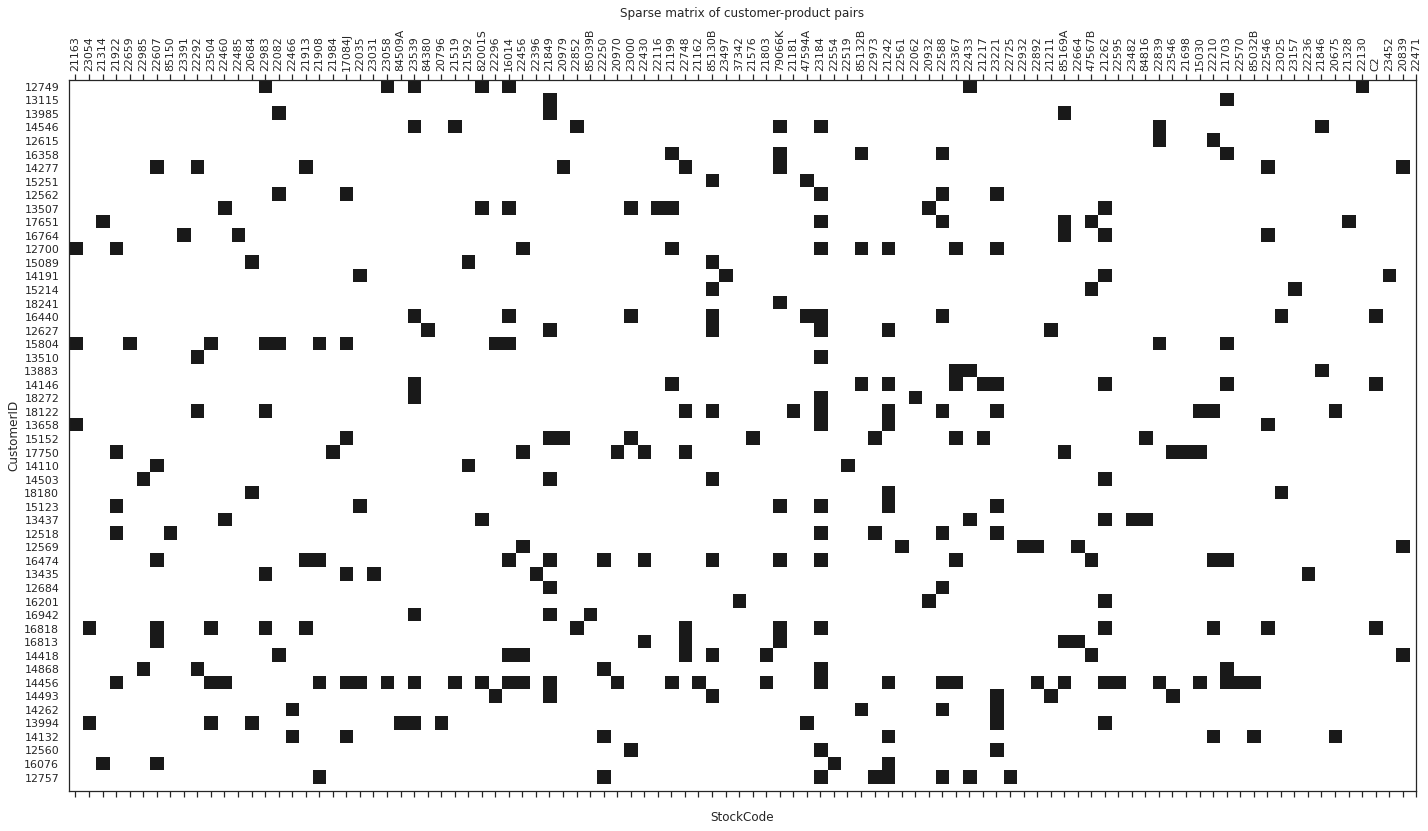

In [127]:
sns.set(style="white")

plt.figure(figsize=(20,60))
plt.spy(df_sparse[df_sparse.columns[1:100]])
plt.xticks(ticks=range(0, 100, 1), labels=list(set(Platinum_selected['StockCode']))[:100], rotation='vertical')
plt.yticks(ticks=range(0, 53, 1), labels=list(set(Platinum_selected['CustomerID']))[:53])
plt.xlabel("StockCode", labelpad=20)
plt.ylabel("CustomerID")
plt.title("Sparse matrix of customer-product pairs", y=1.08)
plt.tight_layout()
plt.show()

The matrix of customers-products is extremely sparse since each customer will only buy very small portion of goods, we choose a subset of products for bettet visualization. As there are no ratings available, we simply regard purchase as 1, otherwise 0.

In [173]:
df_recommend = df_sparse[df_sparse.columns[1:100]]
df_recommend.head()

,23054,21314,21922,22659,22985,22607,85150,23391,22292,23504,22460,22485,20684,22983,22082,22466,21913,21908,21984,17084J,22035,23031,23058,84509A,23539,84380,20796,21519,21592,82001S,22296,16014,22456,22396,21849,20979,22852,85039B,22250,20970,...,21242,22561,22062,20932,22588,23367,22433,21217,23221,22725,22932,22892,21211,85169A,22664,47567B,21262,22595,23482,84816,22839,23546,21698,15030,22210,21703,22570,85032B,22546,23025,23157,22236,21846,20675,21328,22130,C2,23452,20839,22471
12749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
13115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
12615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
#Replace NaN with 0
df_recommend.fillna(0, inplace=True)
df_recommend = df_recommend.astype(float)
df_recommend.head()

,23054,21314,21922,22659,22985,22607,85150,23391,22292,23504,22460,22485,20684,22983,22082,22466,21913,21908,21984,17084J,22035,23031,23058,84509A,23539,84380,20796,21519,21592,82001S,22296,16014,22456,22396,21849,20979,22852,85039B,22250,20970,...,21242,22561,22062,20932,22588,23367,22433,21217,23221,22725,22932,22892,21211,85169A,22664,47567B,21262,22595,23482,84816,22839,23546,21698,15030,22210,21703,22570,85032B,22546,23025,23157,22236,21846,20675,21328,22130,C2,23452,20839,22471
12749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
#Convert dataframe to numpy array
matrix_recommend = df_recommend.to_numpy()
matrix_recommend

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
#Perform SVD, choose number of latent factors as 5
U, sigma, Vt = svds(matrix_recommend, k=5)

In [177]:
#Convert sigma into diagonal matrix
sigma = np.diag(sigma)
sigma

array([[3.91616582, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 3.99615563, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 4.43763792, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 4.84753803, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 7.62439735]])

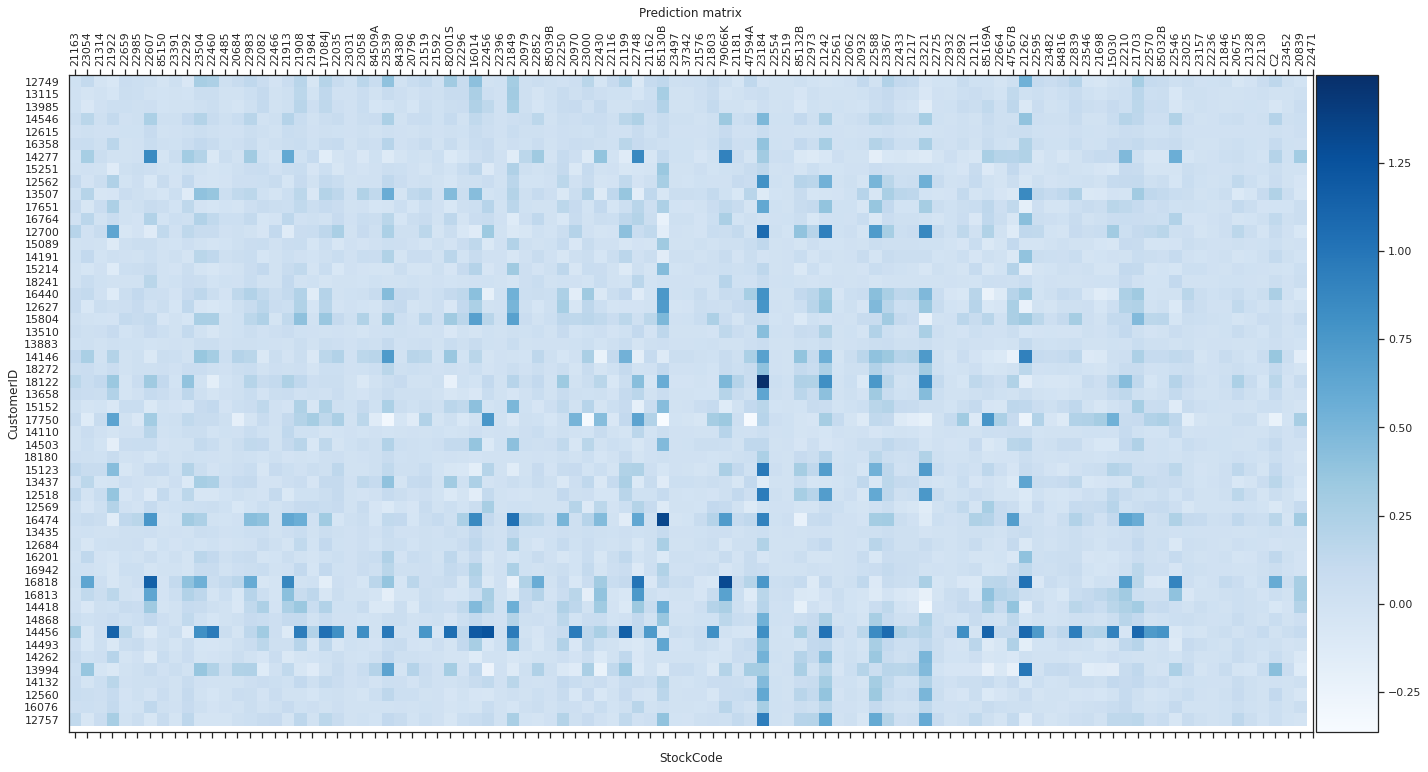

In [201]:
#Predict intention of purchse for each customer
all_customer_predicted = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_customer_predicted, columns=df_recommend.columns, index=df_recommend.index)

#Visualize the predicted matrix
plt.figure(figsize=(20,60))
ax = plt.gca()
im = ax.matshow(preds_df, cmap="Blues")
plt.xticks(ticks=range(0, 100, 1), labels=list(set(Platinum_selected['StockCode']))[:100], rotation='vertical')
plt.yticks(ticks=range(0, 53, 1), labels=list(set(Platinum_selected['CustomerID']))[:53])
plt.xlabel("StockCode", labelpad=20)
plt.ylabel("CustomerID")
plt.title("Prediction matrix", y=1.08)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()

The prediction matrix has turn into a much denser one, making recommendation based on it is more likely to meet needs of customers. 
Besides, it is vital to cater to customers with different styles of advertisements, due to their diversified characteristics: for cluster0, they might be more willing to receive ads connected with Christmas as they are intended to prepare for upcoming festival; for cluster1, products in heart design will be welcomed, so the ads could customize to be more related to such shape; for cluster2, it deserves more effort like offering special offers, because they are former loyal customers, it is beneficial to draw them back; for cluster4, the long-term loyal customers, it might be worth writing a thankyou note to them; for cluster5, coupons would be a stimulus to these lost customers, regarding them as the new ones.
## Conclusion
It has been really a memorable journey to gain some insight of the customer behavior with assistant of data science, the main steps could be summarized as follows:


*   Preprocess and do EDA on attributes of the dataset;
*   Modifie RFM model for quantifying customer values and classifying;
*   Determine the loyal customers and use k-means algorithm for further clustering;
*   Explore properties of each cluster with help of some NLP methods;
*   Perform collaborative filter on the first group.

Finally, give sincere thanks to all my teammates to give awesome support all the way during this journey.





